[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/examples/ZAGamma_simulation_example.ipynb)

# Imports

In [13]:
from xgboostlss.model import *
from xgboostlss.distributions.ZAGamma import *

from sklearn.model_selection import train_test_split 
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
# The simulation example closely follows https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af
np.random.seed(123)
n_samples = 1000

data = pd.DataFrame({"age": np.random.randint(1, 100, size=n_samples)})
data["income"] = np.where((data.age > 17) & (data.age < 70), 1500*data.age + 5000 + 10000*np.random.randn(n_samples), 0) / 1000

y = data["income"].values.reshape(-1,1) 
X = data.drop(columns="income")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Zero-Adjusted Gamma distribution. See ?ZAGamma for an overview.
xgblss = XGBoostLSS(
    ZAGamma(stabilization="None",        # Options are "None", "MAD", "L2".
            response_fn="exp",           # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
            loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).)      
           )           
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-14 11:12:54,804] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-06-14 11:13:01,314] Trial 0 finished with value: 489.663745 and parameters: {'eta': 0.0004994689863651731, 'max_depth': 6, 'gamma': 6.727234032296441e-06, 'subsample': 0.6790691829197013, 'colsample_bytree': 0.5741085583744718, 'booster': 'gbtree'}. Best is trial 0 with value: 489.663745.
[I 2023-06-14 11:13:06,911] Trial 1 finished with value: 353.61188980000003 and parameters: {'eta': 0.07686860410527004, 'max_depth': 6, 'gamma': 0.0001473429854361382, 'subsample': 0.28026420931475604, 'colsample_bytree': 0.4662779757841441, 'booster': 'gbtree'}. Best is trial 1 with value: 353.61188980000003.
[I 2023-06-14 11:13:12,296] Trial 2 finished with value: 365.84898699999997 and parameters: {'eta': 0.02201534223384387, 'max_depth': 2, 'gamma': 0.0007199924645744285, 'subsample': 0.8412759101889264, 'colsample_bytree': 0.8897966334222682, 'booster': 'gbtree'}. Best is trial 1 with value: 353.61188980000003.
[I 2023-06-14 11:13:17,917] Trial 3 finished with value: 489.20664659999994 a

C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract


[I 2023-06-14 11:14:15,018] Trial 12 finished with value: 448.30231319999996 and parameters: {'eta': 0.9759898788003969, 'max_depth': 3, 'gamma': 2.3695381759415525e-08, 'subsample': 0.9913463243727789, 'colsample_bytree': 0.7886146418837507, 'booster': 'gbtree'}. Best is trial 11 with value: 330.74412240000004.
[I 2023-06-14 11:14:16,432] Trial 13 finished with value: 454.17113040000004 and parameters: {'eta': 0.998365650612784, 'max_depth': 4, 'gamma': 1.0627036502681216e-08, 'subsample': 0.9987136143955275, 'colsample_bytree': 0.7318697616922749, 'booster': 'gbtree'}. Best is trial 11 with value: 330.74412240000004.
[I 2023-06-14 11:14:23,050] Trial 14 finished with value: 348.7441408 and parameters: {'eta': 0.13689434948126394, 'max_depth': 1, 'gamma': 2.6458997335625636e-07, 'subsample': 0.8618645700132618, 'colsample_bytree': 0.8427378077293346, 'booster': 'gbtree'}. Best is trial 11 with value: 330.74412240000004.
[I 2023-06-14 11:14:24,467] Trial 15 pruned. Trial was pruned at 

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.204796,102.120705,71.703278,105.628113,89.443787,95.627541,107.683418,94.397614,103.259506,68.001175,...,123.875603,89.156029,107.914062,68.041969,98.416306,107.876129,113.996597,123.945808,91.579063,117.527573
2,43.042534,37.217079,36.585884,44.556767,70.851280,25.616079,28.614723,39.900421,63.246895,20.834999,...,26.661818,32.848087,41.232250,33.875793,48.706497,47.504135,59.874935,48.180283,47.074406,47.412148
3,39.445667,53.570946,50.907501,56.910980,53.622116,45.287960,47.335651,40.071209,66.523354,92.728165,...,56.905788,55.022266,65.082413,51.495502,49.140320,46.178185,35.503922,41.097782,72.074226,57.199459
4,0.000000,0.000000,0.000000,0.000000,0.000000,47.195942,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.000000,0.000000
1,63.945352,120.214192
2,19.138763,60.182043
3,38.923154,76.505629
4,0.000000,0.000000


In [9]:
pred_params.head()

,concentration,rate,gate
0,32.130577,0.302448,0.997929
1,25.962152,0.286466,0.003079
2,10.248434,0.267827,0.003601
3,24.000774,0.423238,0.001000
4,8.810806,0.305360,0.995934


# SHAP Interpretability

C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide


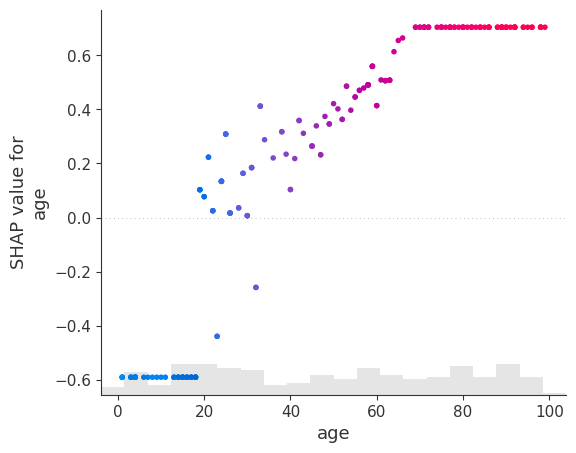

In [10]:
# Partial Dependence Plot of concentration parameter
xgblss.plot(X_test,
            parameter="concentration",
            feature="age",
            plot_type="Partial_Dependence")

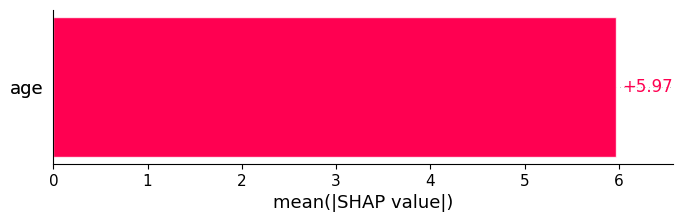

In [11]:
# Feature Importance of gate parameter
xgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

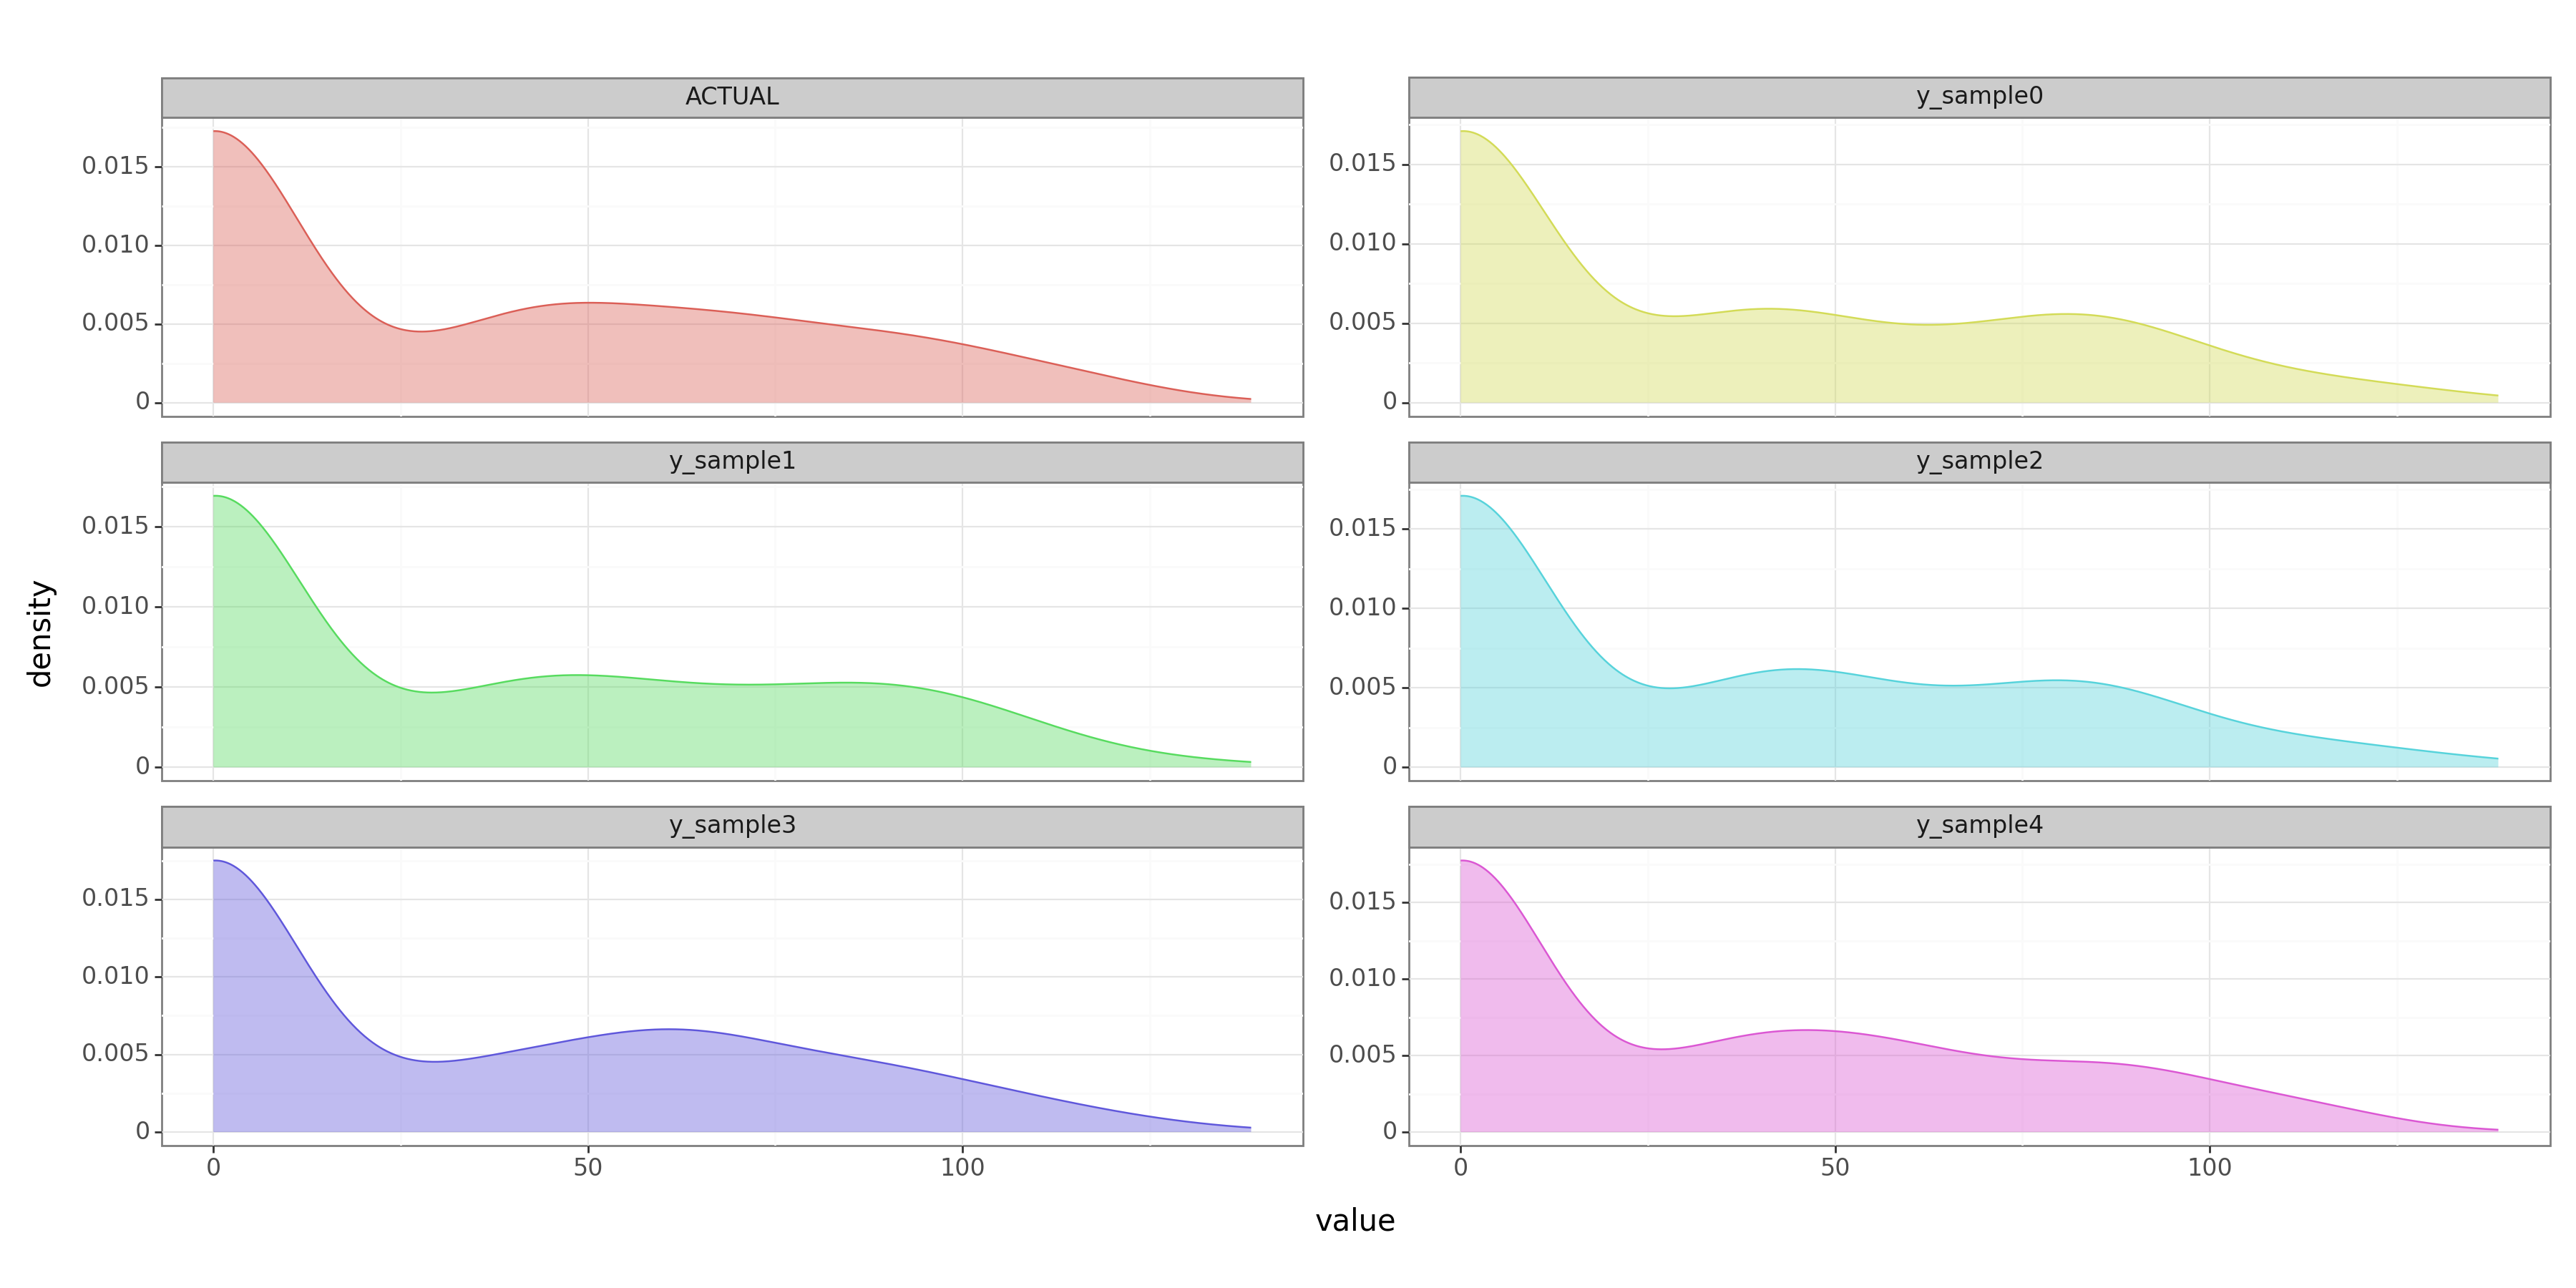

<Figure Size: (1800 x 900)>

In [12]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)